## Reqirements
- tensorflow-gpu or tensorflow = 1.15
- segmenation-models==1.0.*
- albumentations==0.4.5

run with cond_tensorflow_p36

In [1]:
!conda list | grep tensorflow

# packages in environment at /home/ec2-user/anaconda3/envs/tensorflow_p36:
tensorflow-estimator      1.15.1                    <pip>
tensorflow-gpu            1.15.2                    <pip>
tensorflow-serving-api    1.15.0                    <pip>


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3773322154872221904, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12997214049770636750
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15968993248528593407
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15783392052
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8764039653554724930
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"]

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


### Ensure you can see your GPU(s) and note the device index set to 0 below

In [4]:
# Install required libs
!rm -rf build
!rm -rf dist
!rm -rf segmentation_models
!rm -rf segmentation_models.*

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U --pre segmentation-models --user
!git clone https://github.com/qubvel/segmentation_models.git qubvel
!mv qubvel/segmentation_models .
!rm -rf qubvel

Requirement already up-to-date: segmentation-models in /home/ec2-user/.local/lib/python3.6/site-packages (1.0.1)
You should consider upgrading via the 'pip install --upgrade pip' command.
Cloning into 'qubvel'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 922 (delta 13), reused 9 (delta 2), pack-reused 886
Receiving objects: 100% (922/922), 1.82 MiB | 26.28 MiB/s, done.
Resolving deltas: 100% (512/512), done.


In [5]:
!python ./tf_sm_setup.py install

running install
running bdist_egg
running egg_info
creating segmentation_models.egg-info
writing segmentation_models.egg-info/PKG-INFO
writing dependency_links to segmentation_models.egg-info/dependency_links.txt
writing requirements to segmentation_models.egg-info/requires.txt
writing top-level names to segmentation_models.egg-info/top_level.txt
writing manifest file 'segmentation_models.egg-info/SOURCES.txt'
reading manifest file 'segmentation_models.egg-info/SOURCES.txt'
writing manifest file 'segmentation_models.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying segmentation_models.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying segmentation_models.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying segmentation_models.egg-info/dependency_links.txt -> build/b

In [6]:
!pip install albumentations==0.4.5
!pip install --upgrade scikit-image
!pip install numpy==1.15.4 #albumentation requirement... 

You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.16.2)
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/ff/7f/9d804d2348471c67a7d8b5f84f9bc59fd1cefa148986f2b74552f8573555/numpy-1.15.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: tensorflow-gpu 1.15.2 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
You should consider upgrading via the 'pip install --upgrade pip' command.


<span style="color:red; font-size:16pt"> NOTE: please restart the kernel here for installed new libraries to take effect</span>

# Loading dataset

For this example we will use **CubiCasa5k** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 


In [1]:
#if you get an error here its likely you forgot to restart the kernel
import numpy as np
print(np.__version__)
import albumentations as A
print(A.__version__)


1.15.4
0.4.5


In [2]:
DATA_DIR = './data/sagemaker/'
image_width=320 # multiples of 16 for unet
image_height=320 # multiples of 16 for unet
assert(image_width==image_height) #have to be square for unet

In [3]:
!rm -rf {DATA_DIR}/tf_*
#data_bucket = 'kjp-sagemaker-dev'
#!aws s3 cp --quiet --recursive s3://{data_bucket}/floorplans_cubicasa5k/ {DATA_DIR}


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # device index 0, define more gpus with '0,1,2'
os.environ['SM_FRAMEWORK'] = 'tf.keras' 
import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import glob, os
import imageio
import PIL
import numpy as np

def process_files(files, target_dir,mask=False):
    for f in files:
        img = PIL.Image.open(f).convert("L")
        img = img.resize((image_width,image_height), resample=0)
        npimg = np.array(img)
        new_fname = os.path.basename(f).split('.')[0]
        new_fname = new_fname + ".png" 
        imageio.imsave(os.path.join(target_dir, new_fname), npimg.astype(np.uint8))
    return

images = glob.glob(os.path.join(DATA_DIR,'images','*.jpg'))
os.makedirs(DATA_DIR+'/tf_images', exist_ok=True)
process_files(images, os.path.join(DATA_DIR,'tf_images')) 


In [6]:
os.makedirs(DATA_DIR+'/tf_masks', exist_ok=True)
masks = glob.glob(os.path.join(DATA_DIR,'masks','*.png'))
process_files(masks, os.path.join(DATA_DIR,'tf_masks')) 

In [7]:
import glob, os
os.chdir(DATA_DIR)
allfiles = glob.glob("tf_images/*.png")
num_files = len(allfiles)
trainratio = 0.80
num_train = num_files * 0.80
num_test = num_files * 0.90
i = 0
train=[]
test=[]
validation=[]
for file in allfiles:
    if(i<num_train):
        train.append(file)
    elif(i<num_test):
        test.append(file)
    else:
        validation.append(file)
    i = i + 1
with open('tf_train.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)
with open('tf_test.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)
with open('tf_validation.txt', 'w') as f:
    for item in validation:
        f.write("%s\n" % item)
os.chdir("../..")

In [8]:
!pwd
PREFIX = DATA_DIR + "tf_data/"


/home/ec2-user/SageMaker/sagemaker-floorplans


In [9]:
import os
import shutil
from PIL import Image
os.makedirs(DATA_DIR+'tf_data', exist_ok=True)

print(PREFIX)
# Create directory structure mimicing the s3 bucket where data is to be dumped.
os.makedirs(PREFIX+'/train', exist_ok=True)
os.makedirs(PREFIX+'/validation', exist_ok=True)
os.makedirs(PREFIX+'/train_annotation', exist_ok=True)
os.makedirs(PREFIX+'/validation_annotation', exist_ok=True)
os.makedirs(PREFIX+'/test_annotation', exist_ok=True)
os.makedirs(PREFIX+'/test', exist_ok=True)

# Create a list of all training images.
filename = DATA_DIR+'tf_train.txt'
with open(filename) as f:
    train_list = f.read().splitlines() 

# Create a list of all validation images.
filename = DATA_DIR+'tf_validation.txt'
with open(filename) as f:
    val_list = f.read().splitlines() 
    
# Create a list of all validation images.
filename = DATA_DIR+'tf_test.txt'
with open(filename) as f:
    test_list = f.read().splitlines() 

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    im1 = Image.open(DATA_DIR+'/'+i)
    width1, height1 = im1.size
    im2 = Image.open(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'))
    width2, height2 = im2.size
    if(width1!=width2 or height1!=height2): 
        print('skipping training image annotation missmatch ' + 'w1:' + str(width1) +  'w2:' + str(width2) +' h1:' + str(height1) + 'h2:' + str(height2))
    else:
        shutil.copy2(DATA_DIR+'/'+i, PREFIX +'/train/'+i.replace('tf_images', ''))
        shutil.copy2(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'),PREFIX+'/train_annotation/'+i.replace('tf_images', '') )

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in test_list:
    im1 = Image.open(DATA_DIR+'/'+i)
    width1, height1 = im1.size
    im2 = Image.open(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'))
    width2, height2 = im2.size
    if(width1!=width2 or height1!=height2): 
        print('skipping test image annotation missmatch ' + 'w1:' + str(width1) +  'w2:' + str(width2) +' h1:' + str(height1) + 'h2:' + str(height2))
    else:
        shutil.copy2(DATA_DIR+'/'+i, PREFIX +'/test/'+i.replace('tf_images', ''))
        shutil.copy2(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'),PREFIX+'/test_annotation/'+i.replace('tf_images', ''))


# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    im1 = Image.open(DATA_DIR+'/'+i)
    width1, height1 = im1.size
    im2 = Image.open(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'))
    width2, height2 = im2.size
    if(width1!=width2 or height1!=height2): 
        print('skipping validation image annotation missmatch ' + 'w1:' + str(width1) +  'w2:' + str(width2) +' h1:' + str(height1) + 'h2:' + str(height2))
    else:
        shutil.copy2(DATA_DIR+'/'+i, PREFIX+'/validation/'+i.replace('tf_images', ''))
        shutil.copy2(DATA_DIR+'/'+i.replace('tf_images', 'tf_masks'),PREFIX+'/validation_annotation/'+i.replace('tf_images', ''))

./data/sagemaker/tf_data/


In [10]:
x_train_dir = os.path.join(PREFIX, 'train')
y_train_dir = os.path.join(PREFIX, 'train_annotation')

x_valid_dir = os.path.join(PREFIX, 'validation')
y_valid_dir = os.path.join(PREFIX, 'validation_annotation')

x_test_dir = os.path.join(PREFIX, 'test')
y_test_dir = os.path.join(PREFIX, 'test_annotation')

# Dataloader and utility functions 

In [11]:
# helper function for data visualization

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['floorplan', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        #print("start batch index:" + str(start))
        #print("stop batch index:" + str(stop))

        # Make empty arrays for the images and mask batches
        imgs = np.zeros((self.batch_size, *(image_height,image_width), 3))
        msks = np.zeros((self.batch_size, *(image_height,image_width), 1))
        inx = 0 
        for j in range(start, stop):
            img, msk = self.dataset[j]
            imgs[inx, ] = img
            msks[inx, ] = msk
            inx = inx + 1
        
        return (imgs, msks)
    
    def __len__(self):
        """
        The number of batches per epoch
        """
        return self.num_images // self.batch_size


    def get_batch(self, index):
        """
        Public method to get one batch of data
        """
        return self.__getitem__(index)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

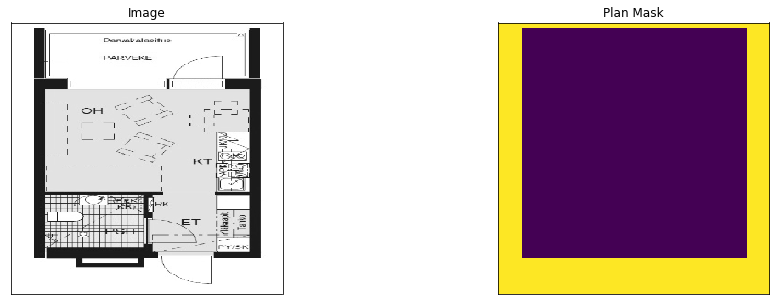

In [12]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['floorplan'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    plan_mask=mask[..., 0].squeeze()
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [13]:
import albumentations as A

### if you get module not found error here, you forgot to restart the kernel at the top please go back 

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=image_height, min_width=image_width, always_apply=True, border_mode=0),
        A.RandomCrop(height=image_height, width=image_width, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=image_height, min_width=image_width)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

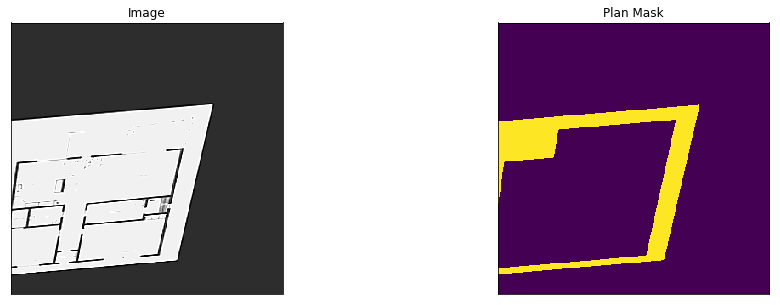

In [15]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['floorplan'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    plan_mask=mask[..., 0].squeeze()
)

# Segmentation model training

In [16]:
import tensorflow as tf
import segmentation_models as sm

# this segmentation_model uses `tf.keras` 
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `tf.keras` framework.


In [17]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['floorplan']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
print(n_classes)
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, decoder_use_batchnorm=False)

1
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
#total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [20]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

print("train_dataloader[0][0].shape")
print(train_dataloader[0][0].shape)
print("train_dataloader[0][1].shape")
print(train_dataloader[0][1].shape)
print("valid_dataloader[0][0].shape")
print(valid_dataloader[0][0].shape)
print("valid_dataloader[0][1].shape")
print(valid_dataloader[0][1].shape)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, image_height, image_width, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, image_height, image_width, n_classes)
assert valid_dataloader[0][0].shape == (1, image_height, image_width, 3)
assert valid_dataloader[0][1].shape == (1, image_height, image_width, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=False, save_best_only=False, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

train_dataloader[0][0].shape
(4, 320, 320, 3)
train_dataloader[0][1].shape
(4, 320, 320, 1)
valid_dataloader[0][0].shape
(1, 320, 320, 3)
valid_dataloader[0][1].shape
(1, 320, 320, 1)


In [21]:
print(len(train_dataloader))
print(len(valid_dataloader))

80
40


In [22]:
!ps aux | grep tensorflow
!nvidia-smi

ec2-user  8910  0.0  0.0 660324 46144 ?        Ssl  Apr19   0:05 /home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m ipykernel -f /home/ec2-user/.local/share/jupyter/runtime/kernel-30f98c5c-cc67-4f37-8923-11ee5df6f08a.json
ec2-user 13088 57.8  2.6 27648972 1691888 ?    Ssl  10:41   1:04 /home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m ipykernel -f /home/ec2-user/.local/share/jupyter/runtime/kernel-117f6f9b-b78e-4fcd-a69b-d30ebb0959ec.json
ec2-user 13569  3.0  0.0 113156  2708 pts/1    Ss+  10:43   0:00 /bin/sh -c ps aux | grep tensorflow
ec2-user 13571  0.0  0.0 110528  2188 pts/1    S+   10:43   0:00 grep tensorflow
Mon Apr 20 10:43:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan 

In [23]:

# train model
history = model.fit(
    x=train_dataloader,
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    use_multiprocessing=False
)



80/80 [==============================] - 15s 192ms/step - loss: 0.1652 - iou_score: 0.8159 - f1-score: 0.8957 - val_loss: 0.1552 - val_iou_score: 0.8612 - val_f1-score: 0.9210
Epoch 26/100
80/80 [==============================] - 15s 190ms/step - loss: 0.1635 - iou_score: 0.8181 - f1-score: 0.8975 - val_loss: 0.1966 - val_iou_score: 0.8069 - val_f1-score: 0.8813
Epoch 27/100
80/80 [==============================] - 15s 192ms/step - loss: 0.1672 - iou_score: 0.8132 - f1-score: 0.8927 - val_loss: 0.1747 - val_iou_score: 0.8384 - val_f1-score: 0.9037
Epoch 28/100
80/80 [==============================] - 15s 191ms/step - loss: 0.1538 - iou_score: 0.8340 - f1-score: 0.9074 - val_loss: 0.1419 - val_iou_score: 0.8738 - val_f1-score: 0.9290
Epoch 29/100
80/80 [==============================] - 15s 192ms/step - loss: 0.1548 - iou_score: 0.8259 - f1-score: 0.9019 - val_loss: 0.1485 - val_iou_score: 0.8640 - val_f1-score: 0.9219
Epoch 30/100
80/80 [==============================] - 15s 191ms/step

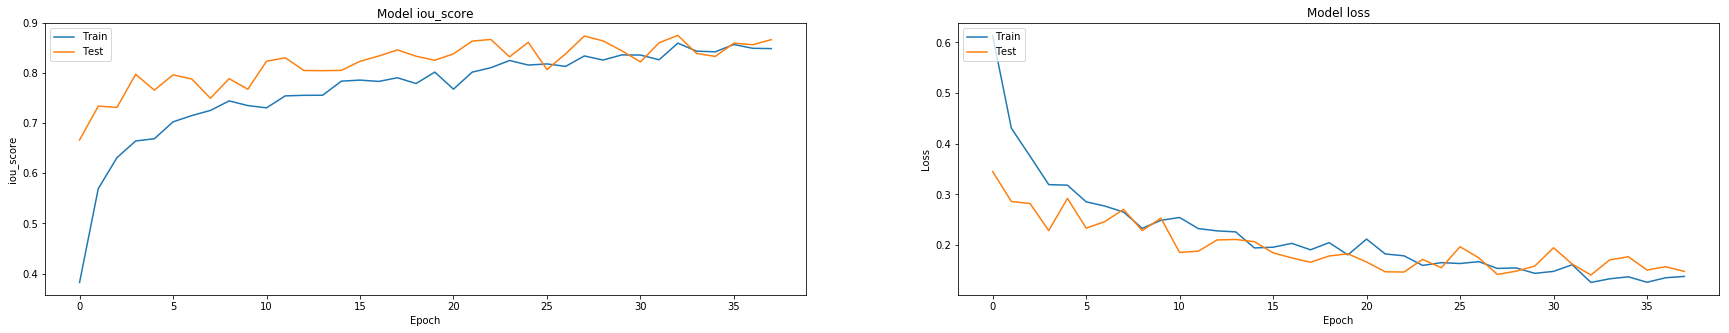

In [24]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [25]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [26]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.15775
mean iou_score: 0.86091
mean f1-score: 0.91984


# Visualization of results on test dataset

In [27]:
# load best weights
model.load_weights('best_model.h5') 

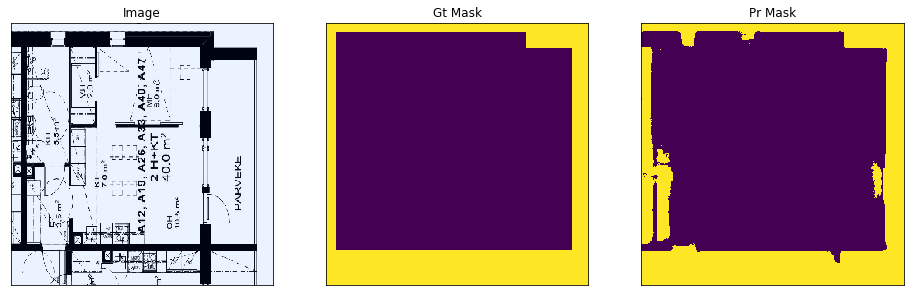

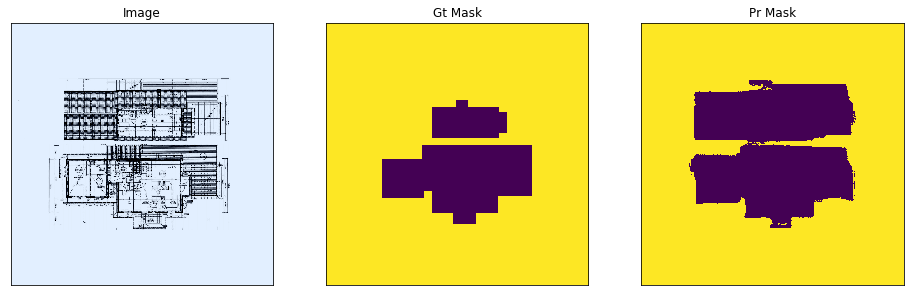

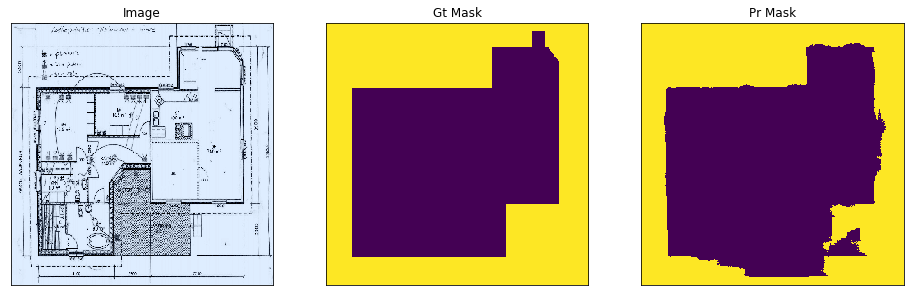

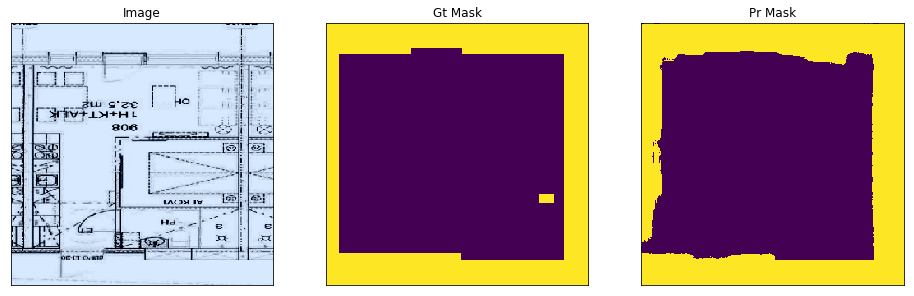

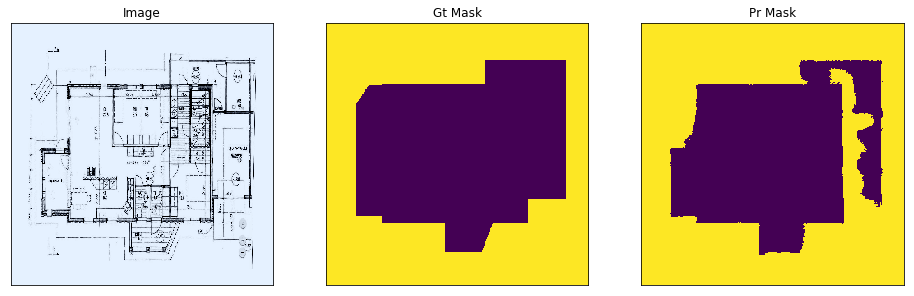

In [28]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

## Deploy to sagemaker

### we save the model locally / load it again and export it for sagemaker for demonstration purpose

In [29]:
!rm -rf ./tf_export
!mkdir ./tf_export

In [30]:
import tensorflow as tf
tf.saved_model.save(model, "./tf_export/imagesegmentation_tf/export/Servo/1/")

INFO:tensorflow:Assets written to: ./tf_export/imagesegmentation_tf/export/Servo/1/assets


In [31]:
!saved_model_cli show --dir ./tf_export/imagesegmentation_tf/export/Servo/1/ --tag_set \
serve --signature_def 'serving_default'


The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['sigmoid'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


#### create inference preprocessing handler for non json requests npy and x-image
https://github.com/aws/sagemaker-tensorflow-serving-container/tree/master#pre/post-processing

In [32]:
!pygmentize tf_inference.py

import base64
import json
from io import BytesIO
import requests
import numpy as np


def input_handler(data, context):
    """ Pre-process request input before it is sent to TensorFlow Serving REST API

    Args:
        data (obj): the request data stream
        context (Context): an object containing request and configuration details

    Returns:
        (dict): a JSON-serializable dict that contains request body and headers
    """
    if context.request_content_type == 'application/x-npy':  # for numpy array tensor
        # invoke endpoint with serialized numpy array as request body, the TensorFlow Serving SignatureDef should assume input dtype: [1, H, W, C=3]
        image_npy = np.load(BytesIO(data.read()))
        return json.dumps({"inputs": image_npy.tolist()})
    
    else:
        _return_error(417, 'Unsupported content type "{}"'.format(context.request_content_type or 'Unknown')) 

def _npy_dumps(data):
    """
    Serialized a numpy array into a stream of npy-formatte

In [33]:
!rm -rf ./tf_export/imagesegmentation_tf/export/Servo/code
!mkdir ./tf_export/imagesegmentation_tf/export/Servo/code
!echo "numpy ~= 1.15.1" > ./tf_export/imagesegmentation_tf/export/Servo/code/requirements.txt
!cp ./tf_inference.py ./tf_export/imagesegmentation_tf/export/Servo/code/inference.py

In [34]:
#https://aws.amazon.com/blogs/machine-learning/bring-your-own-pre-trained-mxnet-or-tensorflow-models-into-amazon-sagemaker/
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('./tf_export/imagesegmentation_tf/export/Servo/1', arcname='imagesegmentation_tf/export/Servo/1', recursive=True)
    archive.add('./tf_export/imagesegmentation_tf/export/Servo/code', arcname='code', recursive=True)


### Deploy endpoint to sagemaker

In [35]:
import boto3, re
from sagemaker import get_execution_role
import sagemaker
#from sagemaker.tensorflow.model import TensorFlowModel
role = get_execution_role()
sagemaker_session = sagemaker.Session()


In [36]:
inputs = sagemaker_session.upload_data(path='./model.tar.gz', key_prefix='tf_image_segmentation_keras')

In [ ]:
from sagemaker.tensorflow.serving import Model

sagemaker_model = Model(model_data='s3://' + sagemaker_session.default_bucket() + '/tf_image_segmentation_keras/model.tar.gz', role=role, framework_version='1.15')

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.p3.2xlarge')


-----------------------!

In [ ]:
print(predictor.endpoint)


tensorflow-inference-2020-04-20-10-59-46-692


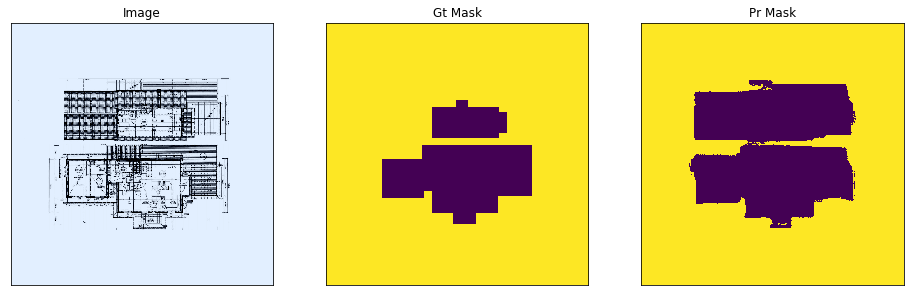

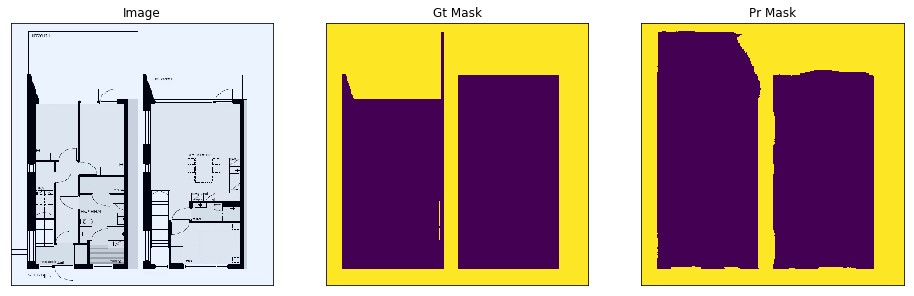

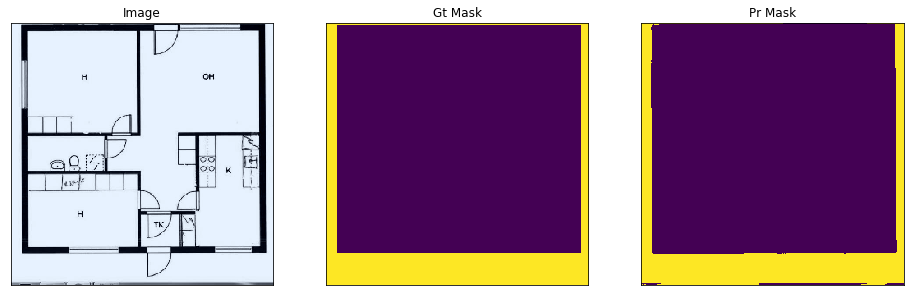

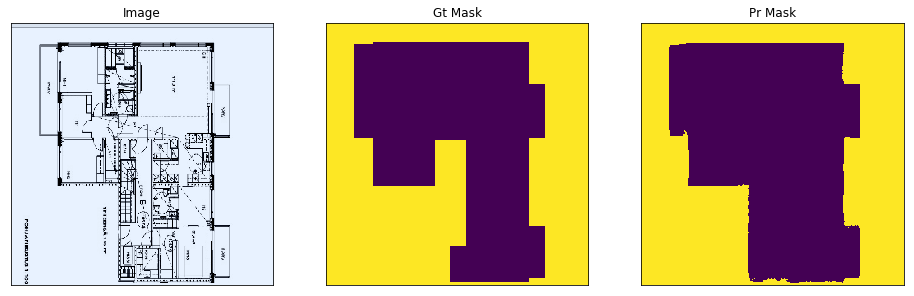

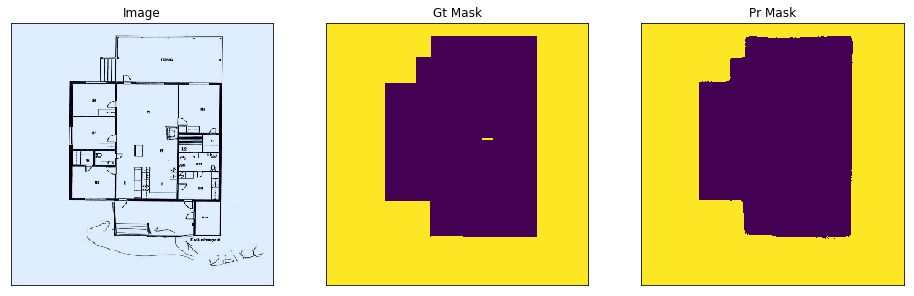

In [ ]:
import base64
import json
from io import BytesIO

from sagemaker.predictor import npy_serializer, numpy_deserializer, json_deserializer
predictor.serializer = npy_serializer
predictor.deserializer = json_deserializer
predictor.accept = 'application/x-json'
predictor.content_type = 'application/x-npy'

n = 5

def _npy_loads(data):
    """
    Deserializes json into a numpy array
    """

    return np.array(data['outputs'])

ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask =  _npy_loads(predictor.predict(image)).round()
    #pr_mask = predictor.predict({ 'instances': instance}).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )